# Notebook 1 - Exploring causal graphs and relationships

In this notebook we'll work through some basic examples of causal relationships, in the form of causal graphs.

__NOTE FOR WINDOWS USERS__: You may need to run the following lines in order for `graphviz` to work in this notebook:

```
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin\' # Or to whatever folder on your machine has the graphviz bin files
```

In [1]:
from causalgraphicalmodels.csm import StructuralCausalModel, linear_model, logistic_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, pearsonr

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
def clean_corr(corr_results):
    """
    Takes the output of the scipy.stats.pearsonr function (Pearson correlation) and cleans it up for easy viewing
    
    Args:
        corr_results: Tuple of floats, the output from scipy.stats.pearsonr
        
    Returns: None
    """
    print(f"r = {round(corr_results[0], 3)} (p =  {round(corr_results[1], 3)})")

## Classic confounding

Let's begin by creating a simple causal model for confounding. Remember, a covariate confounds a relationship between two variables of interest when it causes both. This can induce a spurious association between these two variables if none truly exists.

In the following example, we're looking at how if one were studying the relationship between **coffee consumption** (measured in some continuous way) and **lung cancer symptoms** (measured in some continuous way) can be confounded by **smoking status** (a binary variable)

In [4]:
# Create a toy model here for confounding. We can specify the relationships between three variables
cie_example = StructuralCausalModel({
    "smoking": lambda n_samples: np.random.binomial(1, p=0.30, size=n_samples), 
    "coffee": linear_model(["smoking"], [1.5]),
    "lung cancer risk": linear_model(["smoking"], [6])
})

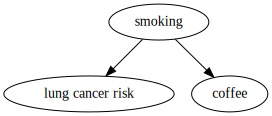

In [9]:
# Let's draw a causal DAG to represent these relationships
cie_cgm = cie_example.cgm
cie_cgm.draw()

Now that we've specified the relationships between these variables, we can simulate a dataset with these relationships...

In [10]:
data = cie_example.sample(n_samples=100000)
data.head()

,smoking,coffee,lung cancer risk
0,1,3.242843,7.276475
1,1,2.877177,4.847065
2,0,0.230027,-1.221785
3,1,1.737583,5.893311
4,0,1.626998,1.142243


A statistical reminder: Pearson correlation coefficients can vary between -1 to 1. -1 indicates a perfect negative/inverse correlation between two variables, while 0 indicates no correlation, and 1 indicates a perfect positive correlation. We can see that there is an apparent moderately strong, positive association between the coffee and lung cancer symptom variables...

In [11]:
clean_corr(
    pearsonr(data['coffee'], data['lung cancer risk'])
)

r = 0.533 (p =  0.0)


As a sanity check, let's plot the relationship between coffee and lung cancer risk

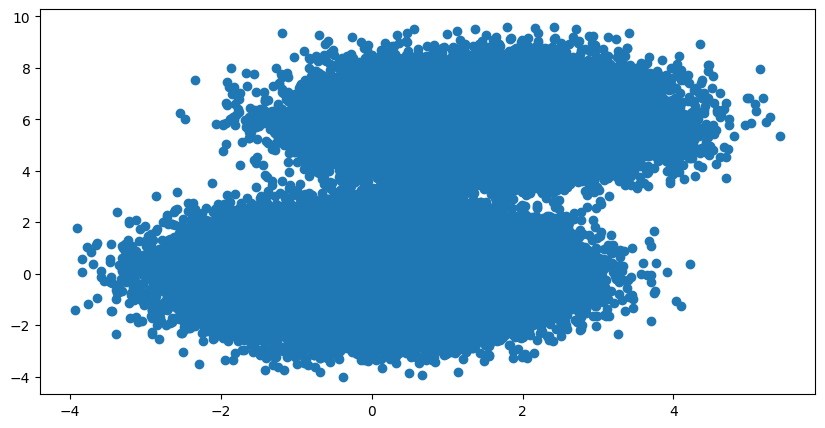

In [12]:
plt.scatter(data['coffee'], data['lung cancer risk'])

There's a lot of overlapping data there, so let's create a hexbin heatmap plot to better see what's going on here.

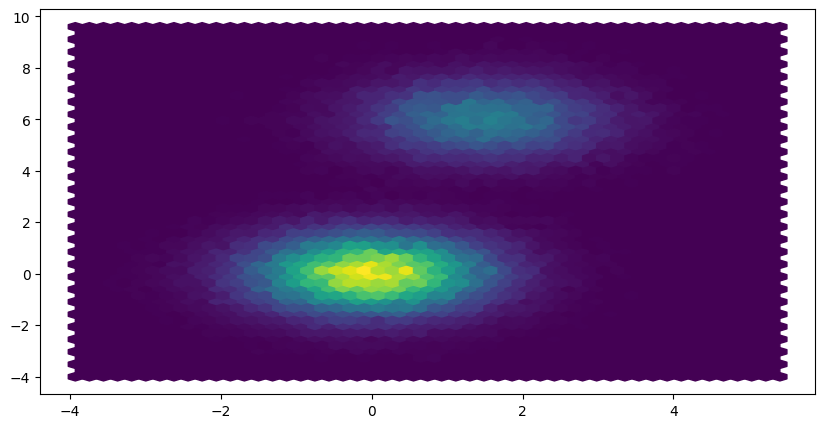

In [13]:
plt.hexbin(data['coffee'], data['lung cancer risk'], gridsize=50)

We can disrupt the confounding by **stratifying** on smoking. Let's filter the dataset so that we only consider smokers (we could just as easily restrict on non-smokers and this would work too)

In [14]:
data2 = data[data['smoking'] == 0]

After we do this, the association between coffee and lung cancer risk vanishes entirely!

In [15]:
clean_corr(
    pearsonr(data2['coffee'], data2['lung cancer risk'])
)

r = -0.0 (p =  0.947)


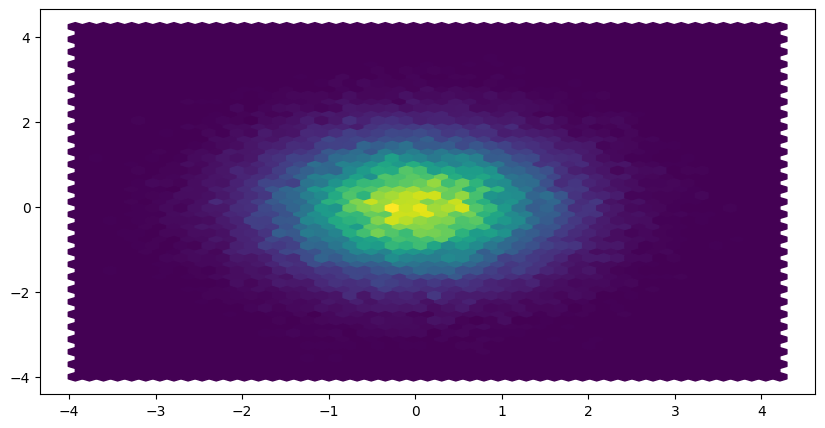

In [16]:
plt.hexbin(data2['coffee'], data2['lung cancer risk'], gridsize=50)

## Collider

Now let's consider a `collider` causal relationship. Remember, controlling for a collider can induce a false association between two variables if you control / stratify on it. For the following exercise, there should **not** be an association between the genetic risk of diabetes and your family's household income when you were a child.

We're going to be looking into a set of three variables here:

* Your mother's genetic risk of diabetes (let's say this is somehow a continuous variable, where higher values indicate a higher risk
* The household income during your childhood (again, let's say this is continuous, where higher values indicate higher income)
* Mother's diabetes: a binary variable, which is causally determined by your mother's genetic risk of diabetes and your household income during childhood 

In [17]:
cie_example = StructuralCausalModel({
    "mother's genetic risk of diabetes": lambda n_samples: np.random.normal(loc=1, scale=0.5, size=n_samples), 
    "household income during your childhood": lambda n_samples: np.random.normal(loc=3, scale=1, size=n_samples), 
    "mother's diabetes": logistic_model(["mother's genetic risk of diabetes", "household income during your childhood"], [1.5,-0.5])
})

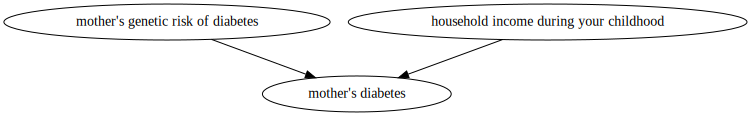

In [18]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [19]:
data = cie_example.sample(n_samples=100000)
data.head()

,mother's genetic risk of diabetes,household income during your childhood,mother's diabetes
0,0.732396,4.295321,0
1,1.297749,4.341040,1
2,0.762828,2.459922,0
3,1.223969,1.919649,0
4,0.620214,1.714793,0


<div class="alert alert-success">
    <h3>EXERCISE: determine the raw association between genetic risk of diabetes and household income during childhood</h3>
</div>

In [20]:
clean_corr(
    pearsonr(data["mother's genetic risk of diabetes"], data['household income during your childhood'])
)

r = 0.001 (p =  0.775)


How strong (or weak) is this correlation? Let's restrict the dataset to only those with high numbers of sick days taken. We've now stratified and controlled for a collider... bad idea.

In [21]:
data2 = data[data["mother's diabetes"] == 1]

<div class="alert alert-success">
    <h3>EXERCISE: Is there still zero association between genetic risk of diabetes and household income during childhood?</h3>
</div>

In [22]:
clean_corr(
    pearsonr(data2["mother's genetic risk of diabetes"], data2['household income during your childhood'])
)

r = 0.072 (p =  0.0)


## Mediation

<div class="alert alert-success">
    <h3>EXERCISE: Create a toy model demonstrating the causal relationship of "mediation". Here's a tip, in three variables you could show that smoking leads to clinical signs of lung damage, which in turn leads to lung cancer.</h3>
    
If you use the above tip, I'd recommend you treat the **smoking** and **lung cancer severity** variables as continuous, which will allow you to calculate a pearson correlation  
    
</div>

In [23]:
cie_example = StructuralCausalModel({
    "smoking": lambda n_samples: np.random.normal(loc=0, scale=0.5, size=n_samples), # Tip: pearson correlations only work between two continuous variables, so in this toy example, let's make smoking and lung cancer continuous...
    "signs of lung damage": logistic_model(["smoking"], [5]),
    "lung cancer severity": linear_model(["signs of lung damage"], [5]),
})

<div class="alert alert-success">
    <h3>EXERCISE: Visualize these relationships and create a simulated dataset for this Mediation exercise</h3>
    
</div>

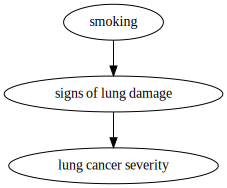

In [25]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [26]:
data = cie_example.sample(n_samples=100000)
data.head()

,smoking,signs of lung damage,lung cancer severity
0,0.145531,1,2.927583
1,-0.634103,0,0.725755
2,0.757691,1,5.300586
3,0.351353,1,4.678352
4,-0.507572,0,-0.803532


<div class="alert alert-success">
    <h3>EXERCISE: Can you demonstrate that there is a relationship between the two outer variables (that are mediated by a third variable)?</h3>
</div>

In [27]:
clean_corr(
    pearsonr(data['smoking'], data['lung cancer severity'])
)

r = 0.608 (p =  0.0)


<div class="alert alert-success">
    <h3>EXERCISE: Try restricting the mediator in this dataset. Basically, filter the dataset so there is no variability in the mediator, and then you have broken the relationship between the two outer variables!</h3>
</div>

In [28]:
data2 = data[data['signs of lung damage'] == 1]

<div class="alert alert-success">
    <h3>EXERCISE: Can you confirm that the relationship between smoking and cancer has been broken?</h3>
</div>

In [29]:
clean_corr(
    pearsonr(data2['smoking'], data2['lung cancer severity'])
)

r = 0.0 (p =  0.96)
